# 単語分散表現

単語分散表現とは、単語の意味を低次元の実数値ベクトルで表現することです。

機械学習・深層学習モデルは、ベクトル（数値の配列）を入力として受け取ります。テキストを扱う際、最初に決めなければならないのは、文字列を機械学習モデルに入力する前に、数値に変換する（あるいはテキストを「ベクトル化」する）ための戦略です。

単語の持つ性質や意味をよく反映するベクトル表現を獲得することは、機械学習・深層学習を自然言語処理で活用するために重要なプロセスです。

- 類似性: ある概念を表現する際に、ほかの概念との共通点や類似性と紐づけながら、ベクトル空間上に表現します。
- 単語類推: 分散表現では異なる概念を表現するベクトル同士での計算が可能です



![類似性](./Figure/word2vec.png)

![単語類推](./Figure/city.png)



単語ベクトルへの変換には様々なアプローチが存在します。最初は、(1)人の手によって作られたシソーラス（類語辞書）を利用する手法について簡単の見ていきます。続いて、統計情報から単語を表現する手法ーカウントベースの手法ーについて説明します。この方法は、言語のモデル化を理解することに役に立つと考られます。そして、ニューラルネットワークを用いた手法(具体的には、word2vwcと呼ばれる手法)を扱います。

1. シソーラスによる手法
    - 人の手によって作られたシソーラス（類語辞書）を利用する手法
2. カウントベースの手法(今週)
    - 統計情報から単語を表現する手法
3. 推論ベースの手法(来週)
    - ニューラルネットワークを用いた手法

## シソーラスによる手法

「単語の意味」を表すためには、人の手によって単語の意味を定義することが考えられます。

シソーラス(thesaurus)と呼ばれるタイプの辞書は、単語間の関係を異表記・類義語・上位下位といった関係性を用いて、単語間の関連を定義できます。

$$
car = auto \ automobile \ machine \ motorcar
$$

![](./Figure/thesaurus.png)


この「単語ネットーワーク」を利用することで、コンピュータに単語間の関連性を伝えることができます。しかし、この手法には大きな欠点が存在します。

- 人の作業コストが高い
- 時代の変化に対応するのが困難
    - 言語は常に進化しており、新しい単語や意味が生まれては消えていくので、シソーラスを最新の状態に保つのは難しいです。
- 単語の些細なかニュアンスを表現できない
    - 単語が持つ複数の意味を区別することは難しい
    - 単語間の関連性はシソーラスでは静的なものであり、動的な文脈や知識の流れを反映しきれないことがあります

## カウントベースの手法

コーパスには、自然言語に対する人の「知識」ー文章の書き方、単語の選び方、単語の意味ーがふんだんに含まれています。カウントベースの手法の目標は、そのような人の知識が詰まったコーパスから自動的に抽出することにあります。

### コーパスの前処理

コーパスに対して、テキストデータを単語に分割し、その分割した単語をID化にすることが必要されます。

単語のID化とは、テキストデータを機械学習モデルなどで処理する際に、単語を一意の整数値（ID）に変換するプロセスを指します。これは、テキストデータをベクトルや行列の形でモデルに入力するための前処理として行われます。


例として、簡単なテキストを用意します。

In [2]:
text = 'You say goodbye and I say hello.'

In [3]:
# 小文字に変換
text = text.lower()
print(text)

# ピリオドの前にスペースを挿入
text = text.replace('.', ' .')
print(text)

# 単語ごとに分割
words = text.split(' ')
print(words)

you say goodbye and i say hello.
you say goodbye and i say hello .
['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']


これで、元の文章を単語リストとして利用できるようになりました。これに基づいて、分割した単語と、単語ごとに通し番号を割り振ったIDを2つのディクショナリに格納します。

In [4]:
# ディクショナリを初期化
word_to_id = {}
id_to_word = {}

# 未収録の単語をディクショナリに格納
for word in words:
    if word not in word_to_id: # 未収録の単語のとき
        # 次の単語のidを取得
        new_id = len(word_to_id)
        
        # 単語IDを格納
        word_to_id[word] = new_id
        
        # 単語を格納
        id_to_word[new_id] = word

In [5]:
# 単語IDを指定すると単語を返す
print(id_to_word)
print(id_to_word[5])

# 単語を指定すると単語IDを返す
print(word_to_id)
print(word_to_id['hello'])

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
hello
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
5


最後に、単語リストから単語IDリストに変換します。

In [6]:
import numpy as np
# リストに変換
corpus = [word_to_id[word] for word in words]

# NumPy配列に変換
corpus = np.array(corpus)
print(corpus)

[0 1 2 3 4 1 5 6]


以上の処理を```preprocess()```という関数として、まとめて実装することにします。

In [7]:
# 前処理関数の実装
def preprocess(text):
    # 前処理
    text = text.lower() # 小文字に変換
    text = text.replace('.', ' .') # ピリオドの前にスペースを挿入
    words = text.split(' ') # 単語ごとに分割
    
    # ディクショナリを初期化
    word_to_id = {}
    id_to_word = {}
    
    # 未収録の単語をディクショナリに格納
    for word in words:
        if word not in word_to_id: # 未収録の単語のとき
            # 次の単語のidを取得
            new_id = len(word_to_id)
            
            # 単語をキーとして単語IDを格納
            word_to_id[word] = new_id
            
            # 単語IDをキーとして単語を格納
            id_to_word[new_id] = word
    
    # 単語IDリストを作成
    corpus = [word_to_id[w] for w in words]
    
    return corpus, word_to_id, id_to_word

In [8]:
# テキストを設定
text = 'You say goodbye and I say hello.'

# 単語と単語IDに関する変数を取得
corpus, word_to_id, id_to_word = preprocess(text)
print(id_to_word)
print(word_to_id)
print(corpus)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
[0, 1, 2, 3, 4, 1, 5, 6]


### 分布仮説

分布仮説（Distributional Hypothesis）は、言語学や自然言語処理の分野で重要な考え方で、単語の意味は、周囲の単語(コンテキスト)によって形成されるというものです。

- 単語は、その単語が出現する文脈の集合によって意味が形成されるとされます。同じ文脈で出現する単語は、意味が似ていると考えられます。
- 単語Aと単語Bが多くの共通の文脈で使用される場合、これらの単語は意味的に関連があると見なされます。

この仮説は、単語の意味を捉えるためのモデルを作成する際に基本的な原則となっています。

![](./Figure/DH.png)

### 共起行列

分布仮説に基づいた単語ベクトル化の方法を考える際、一番素直な方法は、周囲の単語を"カウント"することです。つまり、ある単語に着目した場合、その周囲どのような単語がどれだけ現れるのかをカウントし、それを集計するのです。

ここでは、"*You say goodbye and I say hello.*"という文章について、ウィンドウサイズを$1$とする場合、そのコンテキストに含まれる単語の頻度をカウントしてみます。

```{figure} ./Figure/co-occur.png
---
align: center
---
各単語について、そのコンテキストに含まれす単語の頻度
```


- 「You」の周辺単語は「say」のみであり、「say」にのみコンテキストの目印として共起した回数の$1$をカウントします
- 「say」については文字列中に2回現れていることに注意すると、$[1, 0, 1, 0, 1, 1, 0]$とベクトル表記できます

全ての単語に対して、共起する単語をまとめたものを共起行列と呼ばれます。

In [9]:
# ウィンドウサイズを指定
wndow_size = 1

# 単語の種類数を取得
vocab_size = len(word_to_id)
print(f"単語の種類数: {vocab_size}")

# 総単語数を取得
corpus_size = len(corpus)
print(f"総単語数: {corpus_size}")

単語の種類数: 7
総単語数: 8


In [10]:
# 共起行列を初期化
co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
print(co_matrix)
print(co_matrix.shape)

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
(7, 7)


コーパスの7語目の単語「hello」に注目してみます。

In [11]:
# 単語インデックスを指定
idx = 6

# 指定した単語のIDを取得
word_id = corpus[idx]
print(word_id)
print(id_to_word[word_id])

5
hello


In [12]:
# 左隣のインデックス
left_idx = idx - 1
print(left_idx)

# 右隣のインデックス
right_idx = idx + 1
print(right_idx)

5
7


In [13]:
# 左隣の単語IDを取得
left_word_id = corpus[left_idx]
print(left_word_id)
print(id_to_word[left_word_id])

# 共起行列に記録(加算)
co_matrix[word_id, left_word_id] += 1
print(co_matrix)

1
say
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


In [14]:
# 右隣の単語IDを取得
right_word_id = corpus[right_idx]
print(right_word_id)
print(id_to_word[right_word_id])

# 共起行列に記録(加算)
co_matrix[word_id, right_word_id] += 1
print(co_matrix)

# 対象の単語ベクトル
print(co_matrix[word_id])

6
.
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
[0 1 0 0 0 0 1]


処理を共起行列を作成する関数として実装します。

In [15]:
# 共起行列作成関数の実装
def create_co_matrix(corpus, vocab_size, window_size=1):
    
    # 総単語数を取得
    corpus_size = len(corpus)
    
    # 共起行列を初期化
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    # 1語ずつ処理
    for idx, word_id in enumerate(corpus):
        
        # ウィンドウサイズまでの要素を順番に処理
        for i in range(1, window_size + 1):
            # 範囲内のインデックスを計算
            left_idx = idx - i
            right_idx = idx + i
            
            # 左側の単語の処理
            if left_idx >= 0: # 対象の単語が最初の単語でないとき
                # 単語IDを取得
                left_word_id = corpus[left_idx]
                
                # 共起行列にカウント
                co_matrix[word_id, left_word_id] += 1
            
            # 右側の単語の処理
            if right_idx < corpus_size: # 対象の単語が最後の単語でないとき
                # 単語IDを取得
                right_word_id = corpus[right_idx]
                
                # 共起行列にカウント
                co_matrix[word_id, right_word_id] += 1
    
    return co_matrix

### ベクトル間の類似度

#### コサイン類似度

共起行列によって単語をベクトルで表すことができました。単語の意味を「計算」する手法として、ベクトル間の類似度の計測する方法について見ていきます。

様々な方法がありますが、単語のベクトル表現の類似度に関して、コサイン類似度がよく用いられます。

コサイン類似度とは、2つのベクトルを$\mathbf{x} = (x_1, x_2, \cdots, x_n), \mathbf{y} = (y_1, y_2, \cdots, y_n)$として、次の式で定義されます。

$$
\begin{align}
\mathrm{similarity}(\mathbf{x}, \mathbf{y})
   &= \frac{
          \mathbf{x} \cdot \mathbf{y}
      }{
          \|\mathbf{x}\| \|\mathbf{y}\|
      }
\\
   &= \frac{
          x_1 y_1 + x_2 y_2 + \cdots + x_n y_n
      }{
          \sqrt{x_1^2 + x_2^2 + \cdots + x_n^2}
          \sqrt{y_1^2 + y_2^2 + \cdots + y_n^2}
      }
\\
   &= \frac{
          \sum_{n} x_n y_n
      }{
          \sqrt{\sum_{n} x_n^2}
          \sqrt{\sum_{n} y_n^2}
      }
\end{align}
$$

- 分子はベクトルの内積
- 分母は各ベクトルの「ノルム」(ベクトルの大きさ)があります。

```{margin}
epsは、$0$除算とならないための微小な値です。通常、このような小さな値は浮動小数点の「丸の誤差」により、他の値に"吸収"されますので、最終の計算結果に影響を与えません。
```

In [16]:
# コサイン類似度の実装
def cos_similarity(x, y, eps=1e-8):
    # コサイン類似度を計算:式(2.1)
    nx = x / (np.sqrt(np.sum(x**2)) + eps)
    ny = y / (np.sqrt(np.sum(y**2)) + eps)
    return np.dot(nx, ny)

　実装した関数を使って、ベクトルの値とコサイン類似度の値との関係を見ましょう。

In [17]:
a_vec = np.array([5.0, 5.0])
b_vec = np.array([3.0, 9.0])

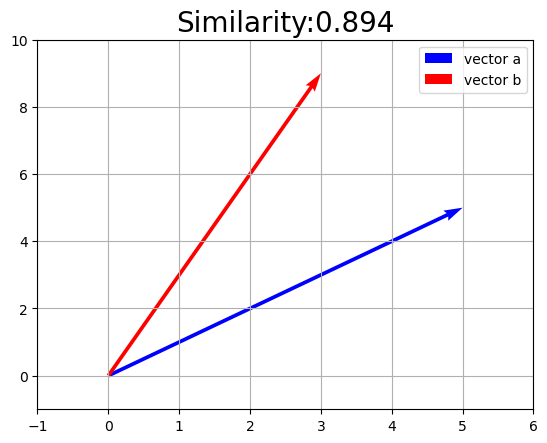

In [18]:
import matplotlib.pyplot as plt
#import seaborn as sns

# Set Seaborn theme
#sns.set_context("paper") # or "talk"
#sns.set_style("whitegrid")

# コサイン類似度を計算
sim_val = cos_similarity(a_vec, b_vec)

# 作図
plt.quiver(0, 0, a_vec[0], a_vec[1], angles='xy', scale_units='xy', scale=1, color='b', label='vector a') # 有効グラフ
plt.quiver(0, 0, b_vec[0], b_vec[1], angles='xy', scale_units='xy', scale=1, color='r', label='vector b') # 有効グラフ
plt.xlim(min(0, a_vec[0], b_vec[0]) - 1, max(0, a_vec[0], b_vec[0]) + 1)
plt.ylim(min(0, a_vec[1], b_vec[1]) - 1, max(0, a_vec[1], b_vec[1]) + 1)
plt.legend() 
plt.grid() 
plt.title('Similarity:' + str(np.round(sim_val, 3)), fontsize=20)
plt.show()

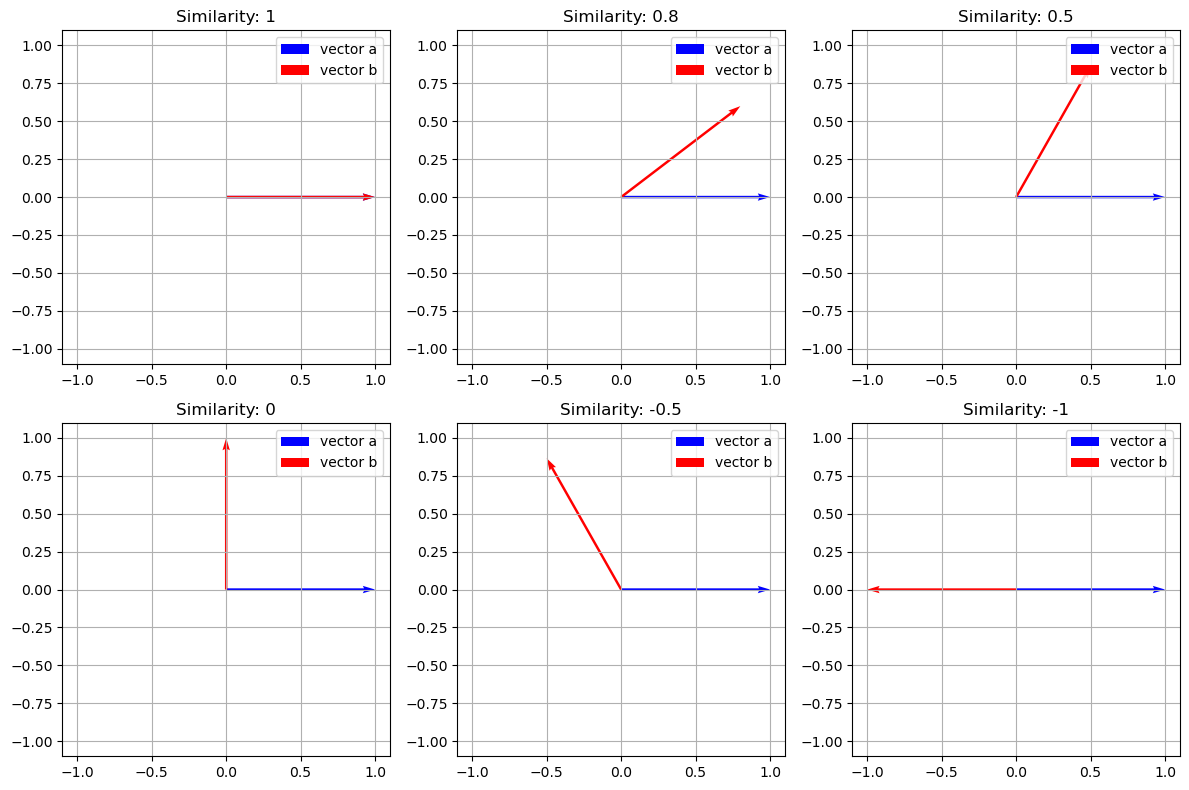

In [25]:
# Function to create a subplot for vectors with a given cosine similarity
def plot_vector_similarity(ax, similarity, vector_a):
    # Generate vector b based on desired cosine similarity and vector a
    angle = np.arccos(similarity)
    vector_b = np.array([np.cos(angle), np.sin(angle)]) * np.linalg.norm(vector_a)
    
    # Plotting the vectors
    ax.quiver(0, 0, vector_a[0], vector_a[1], angles='xy', scale_units='xy', scale=1, color='b', label='vector a')
    ax.quiver(0, 0, vector_b[0], vector_b[1], angles='xy', scale_units='xy', scale=1, color='r', label='vector b')
    
    # Setting the limits of the plot
    lim = np.max(np.abs(np.array([vector_a, vector_b]))) + 0.1
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    
    # Adding grid, legend, and title to the subplot
    ax.legend()
    ax.grid(True)
    ax.set_title('Similarity: ' + str(similarity))

# Initial vector a
a_vec = np.array([1, 0])

# Similarity values to plot
similarities = [1, 0.8, 0.5, 0, -0.5, -1]

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Flatten axes array for easy iteration
axes_flat = axes.flatten()

# Plot each similarity in a subplot
for ax, sim in zip(axes_flat, similarities):
    plot_vector_similarity(ax, sim, a_vec)

plt.tight_layout()
plt.show()

#### 単語間の類似度

前項で作成した各単語ベクトルを用いて、2つの単語の類似度を測りましょう。

　比較したい2つの単語を指定して、単語ベクトルからコサイン類似度を計算します。



In [26]:
# テキストを設定
text = 'You say goodbye and I say hello.'

# 単語と単語IDに関する変数を取得
corpus, word_to_id, id_to_word = preprocess(text)

# 単語の種類数を取得
vocab_size = len(word_to_id)

# 共起行列を作成
word_matrix = create_co_matrix(corpus, vocab_size, window_size=1)

# 単語を指定して単語ベクトルを取得
c0 = word_matrix[word_to_id['you']]
c1 = word_matrix[word_to_id['i']]
print(c0)
print(c1)

# コサイン類似度を計算
sim_val = cos_similarity(c0, c1)
print(sim_val)

[0 1 0 0 0 0 0]
[0 1 0 1 0 0 0]
0.7071067691154799


#### 類似度のランキングを表示

単語の「意味」を分析する際には、ある単語に対して類似した単語を探すことがよく挙げられます。ここでは、指定した単語との類似度が高い単語を調べる関数を実装します。

In [31]:
# 対象とする単語を指定
query = 'you'

# 指定した単語のIDを取得
query_id = word_to_id[query]
print(f"指定した単語のID:{query_id}")

# 指定した単語のベクトルを取得
query_vec = word_matrix[query_id]
print(f"指定した単語のベクトル: {query_vec}")

# コサイン類似度の記録リストを初期化
vocab_size = len(id_to_word)
similarity = np.zeros(vocab_size)

# 各単語コサイン類似度を計算
for i in range(vocab_size):
    similarity[i] = cos_similarity(word_matrix[i], query_vec)

# 値を表示
print("類似度の結果：")
for i,j in zip(list(word_to_id.keys()),np.round(similarity, 5)):
    print(f"{i}:{j}")

指定した単語のID:0
指定した単語のベクトル: [0 1 0 0 0 0 0]
類似度の結果：
you:1.0
say:0.0
goodbye:0.70711
and:0.0
i:0.70711
hello:0.70711
.:0.0


```{margin}
 ``.argsort()``メソッドは、配列の要素の値が小さい順にインデックスを返します。ここで知りたいのは上位のインデックスのため、similarityに-1を掛けて符号を反転させることで、大小関係を逆転させます。
```

In [25]:
# 配列を作成
arr = np.array([0, 20, 10, 40, 30])
print(arr)

# 低い順のインデックス
print(arr.argsort())

# 大小関係を逆転
print(-1 * arr)

# 高い順のインデックス
print((-1 * arr).argsort())

[ 0 20 10 40 30]
[0 2 1 4 3]
[  0 -20 -10 -40 -30]
[3 4 1 2 0]


In [32]:
# 表示する順位を指定
top = 5

# 類似度上位の単語と値を表示
count = 0 # 表示回数を初期化
for i in (-1 * similarity).argsort():
    
    # 指定した単語のときは次の単語に移る
    if id_to_word[i] == query:
        continue
    
    # 単語と値を表示
    print(' %s: %s' % (id_to_word[i], similarity[i]))
    
    # 指定した回数に達したら処理を終了
    count += 1 # 表示回数を加算
    if count >= top:
        break

 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


In [26]:
# 類似度の上位単語を検索関数の実装
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    
    # 指定した単語がテキストに含まれないとき
    if query not in word_to_id:
        print('%s is not found' % query)
        return
    
    # 対象の単語を表示
    print('\n[query] ' + query)
    
    # 指定した単語のIDを取得
    query_id = word_to_id[query]
    
    # 指定した単語のベクトルを取得
    query_vec = word_matrix[query_id]
    
    # コサイン類似度を計算
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
    
    # 類似度上位の単語と値を表示
    count = 0 # 表示回数を初期化
    for i in (-1 * similarity).argsort():
        
        # 指定した単語のときは次の単語に移る
        if id_to_word[i] == query:
            continue
        
        # 単語と値を表示
        print(' %s: %s' % (id_to_word[i], similarity[i]))
        
        # 指定した回数に達したら処理を終了
        count += 1 # 表示回数を加算
        if count >= top:
            return

In [27]:
# クエリを指定
query = 'you'

# 類似の単語を表示
most_similar(query, word_to_id, id_to_word, word_matrix, top=5)


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


## カウントベースの手法の改善

```{margin}
事象$x$の生起確率$p(x)$を基にして情報量$I(x)$は

$$
I(x) = - \log_2 p(x)
$$

になります。$0 \leq p(x) \leq 1$なので、$\log p(x)$は常に負の値になる。よって符号を反転した値を情報量とすることで、常に正の値をとるようにする。$log$の底が$2$なのは、情報学分野において0と1からなるbitとの相性からよく使われるためである。

```

### 相互情報量

ここまでは単語がテキストに出現する頻度そのままを扱いましたが、このやり方によって単語分散を計測する際、高頻度単語によるバイアスは生じる可能性があります。

例えば、日本語において、「の」は非常に一般的な助詞で、さまざまな文脈で使用されます。単語の共起行列を作成するとき、「の」は非常に頻繁に出現し、多くの異なる単語とペアを形成するため、単純な共起頻度はその単語の意味のある関連性を捉えるのには不十分です。

そのような問題を解決するために、相互情報量(Pointwise Mutual Information)と呼ばれる指標が使われます。

2つの単語$x$,$y$の出現確率をそれぞれ$P(x)$,$P(y)$とします。$x$の出現確率は

$$
P(x)
    = \frac{C(x)}{N}
$$

で計算します。ここで$C(x)$は単語$x$が(テキストではなく)コーパス(共起行列)にカウントされた回数、$N$はコーパスの総単語数とします。

また単語$x$,$y$が共起(ウィンドウサイズ内で続けて出現)した回数を$C(x,y)$とします。

$$
P(x, y)
    = \frac{C(x, y)}{N}
$$

これを用いて、単語$x$,$y$の相互情報量(PMI)は次のように定義されます。

$$
\mathrm{PMI}(x, y)
    = \log_2 \frac{
          P(x, y)
      }{
          P(x) P(y)
      }
$$

またこの式は、次のように変形することで

$$
\begin{align}
\mathrm{PMI}(x, y)
   &= \log_2 \left(
          P(x, y)
          \frac{1}{P(x)}
          \frac{1}{P(y)}
      \right)
\\
   &= \log_2 \left( 
          \frac{C(x, y)}{N}
          \frac{N}{C(x)}
          \frac{N}{C(y)}
      \right)
\\
   &= \log_2 \frac{
          C(x, y) N
      }{
          C(x) C(y)
      }
\end{align}
$$

出現回数と総単語数から直接で計算できることが分かります。

ただし出現回数が0のときに不都合が生じるため、次の正の相互情報量(PPMI)を用います。

$$
\mathrm{PPMI}(x, y)
    = \max(0, \mathrm{PMI}(x, y))
$$

